# supernode-edges

The procedure of constructing weighted L-space and P-space edges of the supernode network.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_lspace.json`
2. `data/supernodes/edges_pspace.json`
3. `data/supernodes/edges_pspace_multi.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import routes_fpath, supernodes_fpath, edges_lspace_fpath, edges_pspace_fpath, \
    edges_pspace_multi_fpath

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 5, 5

In [3]:
routes = pd.read_json(routes_fpath)

routes.head(2)

,name,type,direction,stops,id,distance
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125,3.826103


In [4]:
supernodes = pd.read_json(supernodes_fpath)

supernodes.head(2)

,id,stops,diameter,types,lat,lon
0,0,"[4609, 29290, 3082, 17005, 16142, 15984, 16466...",0.331043,"[bus, trolley, tram]",60.017943,30.367853
1,1,"[16964, 4677, 19280, 2545, 49, 26803, 26804, 1...",0.237753,"[bus, tram, trolley, subway]",59.990263,30.254647


In [5]:
n_supernodes = supernodes.shape[0]
n_supernodes

3226

In [6]:
assert (supernodes.index == supernodes['id']).all()

In [7]:
stop_to_supernode = {
    stop: supernode['id']
    for _, supernode in supernodes.iterrows()
    for stop in supernode['stops']
}


def get_supernode_route(route: List[int]) -> List[int]:
    supernode_route = []
    
    for stop in route:
        supernode = stop_to_supernode[stop]
        
        if len(supernode_route) > 0 and supernode_route[-1] == supernode:
            continue
            
        supernode_route.append(supernode)
        
    return supernode_route


routes['supernodes'] = routes['stops'].apply(get_supernode_route)

routes.head(2)

,name,type,direction,stops,id,distance,supernodes
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430,"[626, 836, 837, 17, 309, 75, 310, 202, 2, 24, ..."
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125,3.826103,"[25, 838, 839, 627, 311, 840, 10, 76, 626]"


### L-space

In [8]:
edges = defaultdict(int)

for route in routes['supernodes']:
    for s1, s2 in zip(route, route[1:]):
        if s1 > s2:
            s2, s1 = s1, s2
            
        edges[(s1, s2)] += 1
        
edges = [
    {'s1': s1, 's2': s2, 'w': w}
    for (s1, s2), w in edges.items()
]

edges[:4]

[{'s1': 626, 's2': 836, 'w': 6},
 {'s1': 836, 's2': 837, 'w': 10},
 {'s1': 17, 's2': 837, 'w': 10},
 {'s1': 17, 's2': 309, 'w': 12}]

In [9]:
weighted_edges = [tuple(edge.values()) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3226, 5352)

In [10]:
# pos = get_layout(g)
pos = dict(zip(supernodes['id'], supernodes[['lon', 'lat']].values))

In [11]:
components = list(nx.connected_components(g))
color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}
color = [color[node] for node in g]

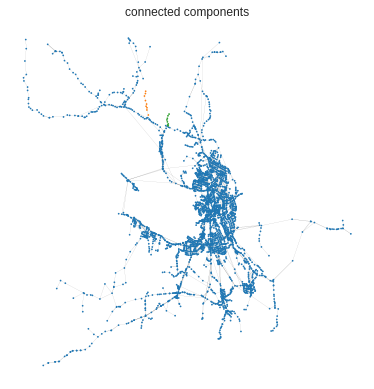

In [12]:
nx.draw(g, pos, node_size=0.5, width=0.05, node_color=color)
plt.title('connected components');

In [13]:
save_json(edges, edges_lspace_fpath)

### P-space

In [14]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [15]:
edges = defaultdict(list)

for route in routes['supernodes']:
    n = len(route)
    
    for i in range(n - 1):
        for j in range(i + 1, n):
            s1 = route[i]
            s2 = route[j]
    
            if s1 > s2:
                s2, s1 = s1, s2
            
            subroute = route[i : j + 1]
            distance = get_route_distance(subroute)
            edges[(s1, s2)].append(distance)
            
single_edges = [
    {'s1': s1, 's2': s2, 'w': min(weights)}
    for (s1, s2), weights in edges.items()
]

multi_edges = [
    {'s1': s1, 's2': s2, 'w': weights}
    for (s1, s2), weights in edges.items()
]

single_edges[:2]

[{'s1': 626, 's2': 836, 'w': 0.44657616594606997},
 {'s1': 626, 's2': 837, 'w': 0.9102138231959868}]

In [16]:
multi_edges[0]

{'s1': 626,
 's2': 836,
 'w': [0.44657616594606997,
  0.44657616594606997,
  0.44657616594606997,
  0.44657616594606997,
  0.44657616594606997,
  0.44657616594606997]}

In [17]:
weighted_edges = [tuple(edge.values()) for edge in single_edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3226, 120039)

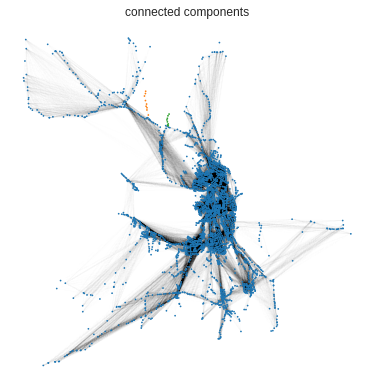

In [18]:
nx.draw(g, pos, node_size=0.5, width=0.002, node_color=color)
plt.title('connected components');

In [19]:
save_json(single_edges, edges_pspace_fpath)
save_json(multi_edges, edges_pspace_multi_fpath)